# Problem Set 6

See [Visualization Rules](https://datascience.quantecon.org/../applications/visualization_rules.html) and [Regression](https://datascience.quantecon.org/../applications/regression.html)

In [23]:
#! pip install patsy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import sklearn
import sklearn.model_selection
import sklearn.ensemble

# Custom imports 
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics

%matplotlib inline

This problem set uses data on insuree characteristics and medical costs. This is a public domain dataset downloaded from [kaggle](https://www.kaggle.com/mirichoi0218/insurance). 

The variables in the data are:
- age: age of primary beneficiary
- sex: insurance contractor gender, female, male
- bmi: Body mass index of primary beneficiary
- children: Number of children covered by health insurance / Number of dependents
- smoker: whether primary beneficiary smokes
- region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
- charges: medical costs billed by health insurance

You will build a  model to predict charges given the other variables in the data. 


In [3]:
insure = pd.read_csv("https://raw.githubusercontent.com/doctor-phil/ECON323_2023_Spring/main/problem_sets/insurance.csv")
insure.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Questions 1-3

These question are intentionally open-ended. For each one, carefully choose the type of visualization you’ll create. Put some effort into choosing colors, labels, and other formatting.

### Question 1

Create a visualization showing the relationship between smoking and medical costs. 

In [4]:
insure.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523


In [8]:
# helper function to graph
# x1 and x2 are variables of interest
# def helper_viz(df, x1, x2):
#     fig, ax = plt.subplots()
#     x1 = df[x1]
#     x2 = df[x2]
#     ax.plot(x1, x2)
#     return 0

<BarContainer object of 1338 artists>

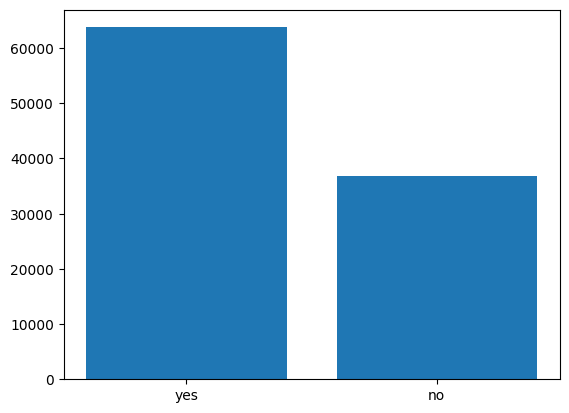

In [11]:
# your code here
# show relationship between smoking (binary) and medical costs
fig, ax = plt.subplots()
ax.bar(insure["smoker"], insure["charges"])


### Question 2

Create a visualization showing the relationship between BMI and medical costs. 

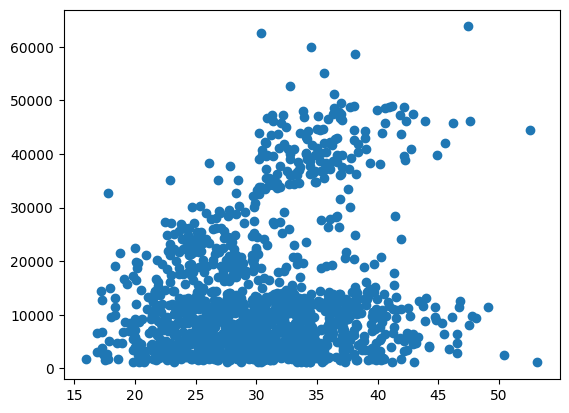

In [13]:
# your code here

# showing the relationship between BMI and medical costs.
fig, ax = plt.subplots()
ax.scatter(x = insure["bmi"], y = insure["charges"])


### Question 3

Does the relationship between medical costs and BMI vary with gender? Create a visualization to answer this question.

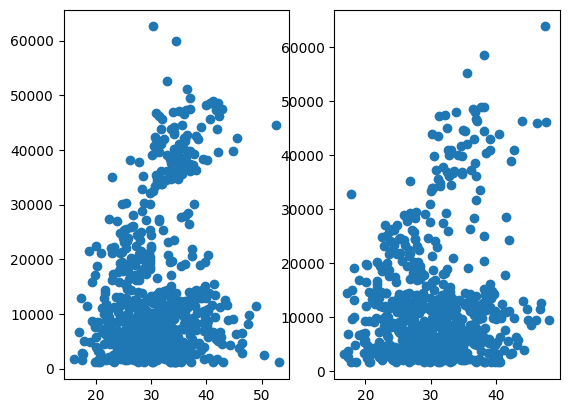

In [15]:
# your code here

# Does the relationship between medical costs and BMI vary with gender
males = insure.query("sex == 'male'")
females = insure.query("sex == 'female'")
fig, ax = plt.subplots(1,2)
ax[0].scatter(males["bmi"], males["charges"],)
ax[1].scatter(females["bmi"], females["charges"])

## Questions 4-7

In these questions you will build and evaluate a model to predict medical costs. 

First, we divide the data into training and testing sets. 

In [16]:
train = insure.sample(frac = 0.8,random_state = 42) 
test = insure.drop(train.index)

Now we create a numeric matrix of features from our dataframe. The formula interface from the patsy package is one convenient method for doing this.

In [17]:
y, X = patsy.dmatrices("charges ~ C(sex)*(age + children + C(smoker) + C(region)) + age:C(smoker)", insure, return_type='matrix')
y = y.flatten()
y_train = y[train.index]
X_train = X[train.index]
y_test = y[test.index]
X_test = X[test.index]

### Question 4

Fit a linear regression model to the training data. Print the MSE on the training and testing data.

In [59]:
# helper to get mses
def report_mses(mod, X_train, X_test, y_train, y_test, name):
    out = dict(
        mse_train=metrics.mean_squared_error(y_train, mod.predict(X_train)),
        mse_test=metrics.mean_squared_error(y_test, mod.predict(X_test))
    )
    print(f"""
    The train MSE of {name} is {round(out["mse_train"], 3)}
    The test MSE of {name} is {round(out["mse_test"], 3)}
    """)
    return out

In [62]:
# your code here

# construct OLS model, fit it to the train data
ols_mod = LinearRegression()
# fit the model
ols_mod = ols_mod.fit(X_train, y_train)

# OLS train and test mses
ols_mses = report_mses(ols_mod, X_train=X_train, X_test=X_test,
                                         y_train=y_train, y_test=y_test, name="OLS")


    The train MSE of OLS is 38781234.249
    The test MSE of OLS is 45740307.025
    


### Question 5

Fit a LASSO model to the training data. Follow along with the notes on regression to visualize the lasso path. `alpha`. Print the MSE on the training and testing data.

In [64]:
# your code here

# Fit LASSO model to train data
lasso_mod = Lasso()
lasso_mod = lasso_mod.fit(X_train, y_train)

# report mses
lasso_mses = report_mses(lasso_mod, X_train=X_train, X_test=X_test,
                                         y_train=y_train, y_test=y_test, name="LASSO")

# Visualize the lasso path

# 


    The train MSE of LASSO is 38781549.541
    The test MSE of LASSO is 45709751.071
    


### Question 6

Estimate a regression tree using the training, data with maximum depth of 3 layers. Set the `random_state` keyword argument to `123`. Report the mean-square error on the training and testing samples as a formatted string. 

Then estimate a regression tree with a maximum depth of 10, and the same value of `random_state` and report its MSE on the test data in the same way.

Which model had a higher MSE on the testing data? Explain why you think this might be.

### Question 7

Perform k-fold cross-validation on the $\alpha$ parameter in your lasso regression, with $k$ equal to `5`. What is the optimal value of $\alpha$ that it chooses? Compare that value of $\alpha$ to the visualization from question 5. How many of your variables have parameters at this level of $\alpha$?